In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

# Para levantar los parquets
import duckdb
from pathlib import Path

from myconfig.cfg import seeds

from myconfig.cfg import ganancia_acierto, costo_estimulo, seeds
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

from typing import List, Optional

import polars as pl
from sklearn import set_config
import numpy as np
import pandas as pd
import gc
import lightgbm as lgb
import optuna
from sklearn.model_selection import StratifiedShuffleSplit
from lightgbm import early_stopping

from __future__ import annotations
from pathlib import Path
import json
import pandas as pd
import lightgbm as lgb


In [2]:
ROOT = Path.cwd().resolve()

PATH_DB = str(ROOT / "data" / "churn.duckdb")

# Paths de cada dataset
# paths = {
#     "reg": (ROOT / "features_reg/**/*.parquet").as_posix(),
#     "delta": (ROOT / "features_delta/**/*.parquet").as_posix(),
#     "minmax": (ROOT / "features_min_max/**/*.parquet").as_posix(),
#     "avg": (ROOT / "features_avg/**/*.parquet").as_posix(),
# }

seed = seeds[0]

base_path = r'/home/joacosk//Documents/maestria/Q2/proyecto'
modelos_path_segmentacion = f'{base_path}/models/'


dataset = '/home/joacosk/Documents/maestria/Q2/proyecto/data/'
clients = 'competencia_01_crudo.csv'

### Creación Target




In [3]:
query = f'''
SELECT *
FROM read_csv_auto("{dataset + clients }")
'''

conn = duckdb.connect(PATH_DB)
df = conn.sql(query).to_df()
conn.close()

In [4]:
q = '''
 SELECT *,
CASE WHEN t1.foto_mes <202106 AND  t1.foto_mes +1  NOT IN
    (SELECT t2.foto_mes
    FROM df as t2
    WHERE t1.numero_de_cliente = t2.numero_de_cliente)  THEN 'BAJA+1'
WHEN t1.foto_mes <202105 AND t1.foto_mes + 2 NOT IN
    (SELECT t2.foto_mes
    FROM df as t2
    WHERE t1.numero_de_cliente = t2.numero_de_cliente)  THEN 'BAJA+2'
WHEN t1.foto_mes <202105 AND t1.foto_mes + 2  IN
    (SELECT t2.foto_mes
    FROM df as t2
    WHERE t1.numero_de_cliente = t2.numero_de_cliente)  THEN 'CONTINUA'
ELSE NULL END AS clase_ternaria
FROM df as t1
'''
conn = duckdb.connect(PATH_DB)
c1= conn.sql(q).to_df()
conn.close()
del(df)


In [5]:
q_create = '''create or replace table competencia_01 as
 select * from c1'''
conn = duckdb.connect(PATH_DB)
conn.sql(q_create)
conn.close()
del(c1)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Feature Engineering

In [10]:
import polars as pl
from typing import List, Tuple


def calcular_ratios(df: pl.DataFrame,):
    sql = """SELECT
    *,
    mpayroll / NULLIF(cpayroll_trx, 0) AS ratio_payroll,
    mtransferencias_recibidas / NULLIF(ctransferencias_recibidas, 0) AS ratio_transferencias_recibidas,
    mcomisiones_otras / NULLIF(ccomisiones_otras, 0) AS ratio_comisiones_otras,
    mcomisiones_mantenimiento / NULLIF(ccomisiones_mantenimiento, 0) AS ratio_comisiones_mantenimiento,
    mtarjeta_visa_consumo / NULLIF(ctarjeta_visa_transacciones, 0) AS ratio_tarjeta_visa_consumo,
    Master_mconsumototal / NULLIF(Master_cconsumos, 0) AS ratio_master_consumo,
    mtransferencias_emitidas / NULLIF(ctransferencias_emitidas, 0) AS ratio_transferencias_emitidas,
    Visa_mconsumototal / NULLIF(Visa_cconsumos, 0) AS ratio_visa_consumo,
    mtarjeta_master_consumo / NULLIF(ctarjeta_master_transacciones, 0) AS ratio_tarjeta_master_consumo,
    --mtarjeta_visa_debitos_automaticos / NULLIF(ctarjeta_visa_debitos_automaticos, 0) AS ratio_visa_debitos_auto,
    --mtarjeta_master_debitos_automaticos / NULLIF(ctarjeta_master_debitos_automaticos, 0) AS ratio_visa_debitos_auto,
    mcaja_ahorro / NULLIF(ccaja_ahorro, 0) AS ratio_caja_ahorro,
    --mpasivos_margen / NULLIF(cpasivos_margen, 0) AS ratio_pasivos_margen,
    mcuenta_corriente / NULLIF(ccuenta_corriente, 0) AS ratio_cuenta_corriente,
    mtarjeta_master_descuentos / NULLIF(ctarjeta_master_descuentos, 0) AS ratio_master_descuentos,
    (mplazo_fijo_dolares + mplazo_fijo_pesos) / NULLIF(cplazo_fijo, 0)  / NULLIF(cplazo_fijo, 0) AS ratio_pf_dolares,
    mprestamos_personales / NULLIF(cprestamos_personales, 0) AS ratio_prestamos_personales,
    mprestamos_hipotecarios / NULLIF(cprestamos_hipotecarios, 0) AS ratio_prestamos_hipotecarios,
    mcheques_depositados_rechazados / NULLIF(ccheques_depositados_rechazados, 0) AS ratio_cheques_dep_rechazados,
    (minversion1_pesos + minversion1_dolares) / cinversion1 as ratio_inversion_1,
    minversion2 / cinversion2 as ratio_inversion_2 ,
    mprestamos_prendarios / NULLIF(cprestamos_prendarios, 0) AS ratio_prestamos_prendarios,
    mcheques_depositados / NULLIF(ccheques_depositados, 0) AS ratio_cheques_depositados,
    mcheques_emitidos / NULLIF(ccheques_emitidos, 0) AS ratio_cheques_emitidos,
    mcheques_emitidos_rechazados / NULLIF(ccheques_emitidos_rechazados, 0) AS ratio_cheques_emitidos_rechazados,
    mforex_buy / NULLIF(cforex_buy, 0) AS ratio_forex_buy,
    mforex_sell / NULLIF(cforex_sell, 0) AS ratio_forex_sell,
    mpayroll2 / NULLIF(cpayroll2_trx, 0) AS ratio_payroll2,
    mpagodeservicios / NULLIF(cpagodeservicios, 0) AS ratio_pagodeservicios
    FROM df"""
    conn = duckdb.connect(PATH_DB)
    df = conn.sql(sql).pl()
    conn.close()
    return df



def get_numeric_columns_pl(
    df: pl.DataFrame,
    exclude_cols: Tuple[str, ...] = ()
) -> List[str]:
    """
    Devuelve las columnas numéricas del DataFrame `df`
    excluyendo las especificadas en `exclude_cols`.
    Equivalente a la versión DuckDB pero operando directamente sobre Polars.
    """
    # tipos numéricos soportados
    numeric_types = {
        pl.Int8, pl.Int16, pl.Int32, pl.Int64,
        pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
        pl.Float32, pl.Float64, pl.Decimal
    }
    # recorrer el schema del df
    numeric_cols = [
        name
        for name, dtype in df.schema.items()
        if dtype in numeric_types and name not in exclude_cols
    ]
    return numeric_cols

def feature_engineering_lag(df: pl.DataFrame, columnas: List[str], cant_lag: int = 1) -> pl.DataFrame:
    sql = "SELECT "
    for i, attr in enumerate(columnas):
        if attr in df.columns:
            sql += f"{attr}, lag({attr}, {i}) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS {attr}_lag_{i}, "
        else:
            print(f"El atributo {attr} no existe en el DataFrame")

    # Completar la consulta
    sql += " * FROM df"
    print(f"Consulta SQL: {sql}")

    # Ejecutar la consulta
    con = duckdb.connect(database=":memory:")
    con.register("df", df)
    df = con.execute(sql).pl()
    con.close()
    print(f"Se han calculado lags de {cant_lag} orden para {len(columnas)} columnas.")
    return df

def feature_engineering_delta(
    df: pl.DataFrame,
    columnas: List[str],
    cant_lag: int = 1,
    exclude_cols: Optional[List[str]] = None,   # <--- NUEVO: lista de columnas a excluir (p.ej. matching_features)
) -> pl.DataFrame:
    """
    Agrega columnas de deltas para cada columna numérica indicada:
    delta_{col}_{k} = col - LAG(col, k)  (por cliente y ordenado por foto_mes)

    Params
    ------
    df : pl.DataFrame
        Requiere 'numero_de_cliente' y 'foto_mes'
    columnas : List[str]
        Columnas candidatas a calcular deltas
    cant_lag : int
        k máximo de los lags (k = 1..cant_lag)
    exclude_cols : List[str] | None
        Columnas que NO deben tener delta (ej: matching_features)
    """
    if cant_lag < 1:
        return df

    skip = set(exclude_cols or [])

    # Filtrar columnas existentes, numéricas y no excluidas
    cols_ok: List[str] = []
    for c in columnas:
        if c not in df.columns:
            print(f"El atributo {c} no existe en el DataFrame")
            continue
        dtype = df.schema.get(c)
        if dtype not in pl.NUMERIC_DTYPES:
            print(f"El atributo {c} no es numérico, se omite")
            continue
        if c in skip:
            # clave: no generar deltas para columnas excluidas (p.ej. matching_features)
            print(f"El atributo {c} está en exclude_cols; se omite")
            continue
        cols_ok.append(c)

    if not cols_ok:
        print("No hay columnas válidas para calcular deltas.")
        return df

    # SELECT: todas las columnas (*) + las deltas
    select_parts = ["*"]
    for attr in cols_ok:
        for k in range(1, cant_lag + 1):
            select_parts.append(
                f"({attr} - lag({attr}, {k}) "
                f"OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes)) "
                f"AS delta_{attr}_{k}"
            )

    sql = "SELECT " + ", ".join(select_parts) + " FROM df"
    print(f"Consulta SQL (deltas): {sql}")

    con = duckdb.connect(database=":memory:")
    try:
        con.register("df", df)
        out = con.execute(sql).pl()
    finally:
        con.close()
        print(f"Se han calculado {cant_lag} deltas para {len(cols_ok)} campos (excluidas: {len(skip)}).")
    return out



In [11]:
conn = duckdb.connect(PATH_DB)
q = 'select * from competencia_01'
data = conn.sql(q).pl()
conn.close()

In [12]:
categorical_features = [
    'active_quarter',
    'cliente_vip'
    ,'internet'
    ,'toaquete3'
    ,'tpaquete4'
    ,'tcuentas'
    ,'ccaja_seguridad'
    ,'thomebanking'
    ,'tmobile_app'
    ,'Master_deliquency'
    ,'Master_status'
    ,'Visa_delinquency'
    ,'Visa_status'
]

matching_categorical_features = [feature for feature in data.columns
                                 if any(cat in feature for cat in categorical_features)]

In [13]:
# Selecciono features numéricas

data = calcular_ratios(data)

numeric_cols = get_numeric_columns_pl(data, exclude_cols=["numero_de_cliente","foto_mes"])

# Genero LAGS de features numéricas
data = feature_engineering_lag(
            data,
            numeric_cols,
            cant_lag=2,
        )

# Marco features categóricas
matching_categorical_features = [feature for feature in data.columns
                                 if any(cat in feature for cat in categorical_features)]

# Genero deltas excluyendo las features categóricas
data = feature_engineering_delta(data,
                                 numeric_cols,
                                 exclude_cols=matching_categorical_features,
                                 cant_lag=2)

Consulta SQL: SELECT active_quarter, lag(active_quarter, 0) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS active_quarter_lag_0, cliente_vip, lag(cliente_vip, 1) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS cliente_vip_lag_1, internet, lag(internet, 2) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS internet_lag_2, cliente_edad, lag(cliente_edad, 3) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS cliente_edad_lag_3, cliente_antiguedad, lag(cliente_antiguedad, 4) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS cliente_antiguedad_lag_4, mrentabilidad, lag(mrentabilidad, 5) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS mrentabilidad_lag_5, mrentabilidad_annual, lag(mrentabilidad_annual, 6) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS mrentabilidad_annual_lag_6, mcomisiones, lag(mcomisiones, 7) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS mcomisiones_lag_7, mactivos_margen, lag(mactivos_marg

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Se han calculado lags de 2 orden para 178 columnas.
El atributo active_quarter está en exclude_cols; se omite
El atributo cliente_vip está en exclude_cols; se omite
El atributo internet está en exclude_cols; se omite
El atributo tcuentas está en exclude_cols; se omite
El atributo ccaja_seguridad está en exclude_cols; se omite
El atributo thomebanking está en exclude_cols; se omite
El atributo tmobile_app está en exclude_cols; se omite
El atributo Master_status está en exclude_cols; se omite
El atributo Visa_delinquency está en exclude_cols; se omite
El atributo Visa_status está en exclude_cols; se omite
Consulta SQL (deltas): SELECT *, (cliente_edad - lag(cliente_edad, 1) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes)) AS delta_cliente_edad_1, (cliente_edad - lag(cliente_edad, 2) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes)) AS delta_cliente_edad_2, (cliente_antiguedad - lag(cliente_antiguedad, 1) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes)) AS delta_cli

/tmp/ipykernel_2277965/400034264.py:121: DeprecationWarning: `NUMERIC_DTYPES` was deprecated in version 1.0.0. Define your own data type groups or use the `polars.selectors` module for selecting columns of a certain data type.
  if dtype not in pl.NUMERIC_DTYPES:


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Se han calculado 2 deltas para 168 campos (excluidas: 30).


In [14]:
conn = duckdb.connect(PATH_DB)
q="""
create or replace table competencia_01_features as
select * from data;
"""
conn.sql(q)
conn.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Lectura data

### DATA DRIFTING

In [18]:

def psi(expected: pl.Series, actual: pl.Series, buckets: int = 10, eps: float = 1e-12) -> float:
    """
    Population Stability Index entre dos series de Polars (expected vs actual).
    - Bins definidos por cuantiles de 'expected'.
    - Maneja nulos (aporta un término PSI por el "bucket nulos").
    - Evita divisiones por cero con un piso eps.
    """
    # Drop de nulos para el cálculo principal
    exp_nn = expected.drop_nulls().to_numpy()
    act_nn = actual.drop_nulls().to_numpy()

    # Si no hay variación o no hay datos, PSI 0
    if exp_nn.size == 0 or act_nn.size == 0:
        # Aún así incluimos el término de nulos si corresponde
        psi_null = 0.0
        if (expected.len() - expected.null_count()) != expected.len() or (actual.len() - actual.null_count()) != actual.len():
            e_null = expected.null_count() / max(expected.len(), 1)
            a_null = actual.null_count() / max(actual.len(), 1)
            e_null = max(e_null, eps)
            a_null = max(a_null, eps)
            psi_null = (a_null - e_null) * np.log(a_null / e_null)
        return float(psi_null)

    # Cuantiles de expected para definir cortes
    # Usamos buckets+1 puntos (incluye min y max). Quitamos duplicados por empates.
    q = np.linspace(0, 1, buckets + 1)
    breakpoints = np.quantile(exp_nn, q)
    breakpoints = np.unique(breakpoints)

    # Si por empates quedan <2 puntos, no hay bins válidos -> PSI 0 (salvo nulos)
    if breakpoints.size < 2:
        psi_null = 0.0
        if expected.null_count() + actual.null_count() > 0:
            e_null = expected.null_count() / expected.len()
            a_null = actual.null_count() / actual.len()
            e_null = max(e_null, eps)
            a_null = max(a_null, eps)
            psi_null = (a_null - e_null) * np.log(a_null / e_null)
        return float(psi_null)

    # Histograma por los cortes
    exp_counts, _ = np.histogram(exp_nn, bins=breakpoints)
    act_counts, _ = np.histogram(act_nn, bins=breakpoints)

    # Proporciones (con piso eps para evitar log/0)
    exp_prop = exp_counts / max(exp_nn.size, 1)
    act_prop = act_counts / max(act_nn.size, 1)
    exp_prop = np.maximum(exp_prop, eps)
    act_prop = np.maximum(act_prop, eps)

    # PSI para no-nulos
    psi_not_null = np.sum((act_prop - exp_prop) * np.log(act_prop / exp_prop))

    # PSI por nulos (si hay nulos en alguna de las dos)
    psi_null = 0.0
    if expected.null_count() + actual.null_count() > 0:
        e_null = expected.null_count() / expected.len()
        a_null = actual.null_count() / actual.len()
        e_null = max(e_null, eps)
        a_null = max(a_null, eps)
        psi_null = (a_null - e_null) * np.log(a_null / e_null)

    return float(psi_not_null + psi_null)


In [23]:
# Revision Drifting
conn = duckdb.connect(PATH_DB)
q = 'select * from competencia_01 where foto_mes in (202101,202102,202103,202104)'
train_data = conn.sql(q).pl()

q = 'select * from competencia_01 where foto_mes = 202106'
score_data = conn.sql(q).pl()
conn.close()


train_null_percentage = train_data.null_count() / train_data.height * 100
score_null_percentage = score_data.null_count() / score_data.height * 100

In [24]:
exclude = {'foto_mes', 'clase_ternaria'}

# Detectar numéricas en Polars correctamente
numeric_types = (pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                 pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                 pl.Float32, pl.Float64)

numeric_cols = [
    c for c, dt in zip(train_data.columns, train_data.dtypes)
    if c not in exclude and isinstance(dt, numeric_types)
]

results = [(c, psi(train_data[c], score_data[c])) for c in numeric_cols]

psi_df = pl.DataFrame(results, schema=["feature", "psi"]).sort("psi", descending=True)
psi_df

/tmp/ipykernel_2331697/3138971248.py:15: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  psi_df = pl.DataFrame(results, schema=["feature", "psi"]).sort("psi", descending=True)


feature,psi
str,f64
"""Visa_fultimo_cierre""",16.287534
"""Master_Finiciomora""",11.657212
"""Master_fultimo_cierre""",10.902024
"""Visa_Finiciomora""",6.587767
"""mpayroll""",0.258512
…,…
"""ccajas_depositos""",0.0
"""ccajas_extracciones""",0.0
"""ccajas_otras""",0.0


### Train y test

In [3]:
conn = duckdb.connect(PATH_DB)
q = 'select * from competencia_01_features limit 1 '
data = conn.sql(q).pl()
conn.close()

In [4]:
# Saco los campos que están relacionados a estas columnas

patrones = [
    "Visa_fultimo_cierre",
    "Master_Finiciomora",
    "Master_fultimo_cierre",
    "Visa_Finiciomora"
]

cols= [
    c for c in data.columns
    if not any(pat in c for pat in patrones)
]

data = data.select(cols)

In [5]:
features = ' ,'.join(cols)
table = 'competencia_01_features'
query = f'select {features} from {table} where foto_mes in (202101,202102,202103,202104,202106)'

conn = duckdb.connect(PATH_DB)
data = conn.sql(query).pl()
conn.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [6]:
data = data.with_columns([
    pl.when(pl.col("clase_ternaria") == "BAJA+2").then(1.00002)
    .when(pl.col("clase_ternaria") == "BAJA+1").then(1.00001)
    .otherwise(1.0)
    .alias("clase_peso")
])

data = data.with_columns([
    pl.when(pl.col("clase_ternaria") == "BAJA+2").then(1).otherwise(0).alias("clase_binaria1"),
    pl.when(pl.col("clase_ternaria") == "CONTINUA").then(0).otherwise(1).alias("clase_binaria2"),
])

In [7]:
train_data = data.filter(
    pl.col("foto_mes") <=  202103
)
test_data  = data.filter(pl.col("foto_mes") == 202104)
pred_data = data.filter(pl.col("foto_mes") == 202106)

# Features / targets / weights en Polars
X_train_pl = train_data.drop(["clase_ternaria", "clase_peso", "clase_binaria1", "clase_binaria2"])
X_test_pl  = test_data.drop(["clase_ternaria", "clase_peso", "clase_binaria1", "clase_binaria2"])

# data set a predecir
X_pred = pred_data.drop(["clase_ternaria", "clase_peso", "clase_binaria1", "clase_binaria2"])

y_train_binaria1 = train_data["clase_binaria1"].to_numpy().ravel()
y_train_binaria2 = train_data["clase_binaria2"].to_numpy().ravel()
w_train          = train_data["clase_peso"].to_numpy().ravel().astype(float)

y_test_binaria1  = test_data["clase_binaria1"].to_numpy().ravel()
y_test_binaria2  = test_data["clase_binaria2"].to_numpy().ravel()

y_test_class     = test_data["clase_ternaria"].to_numpy()  # si lo usás luego
w_test           = test_data["clase_peso"].to_numpy().ravel().astype(float)


In [8]:
### Vuelvo a elegir los campos categóricos

categorical_features = [
    'active_quarter',
    'cliente_vip'
    #, 'internet'
    , 'toaquete3'
    , 'tpaquete4'
    , 'tcuentas'
    , 'ccaja_seguridad'
    , 'thomebanking'
    , 'tmobile_app'
    , 'Master_deliquency'
    , 'Master_status'
    , 'Visa_delinquency'
    , 'Visa_status'
]

matching_categorical_features = [feature for feature in data.columns
                                 if any(cat in feature for cat in categorical_features)]


In [9]:

set_config(transform_output="pandas")

Xi  = X_train_pl.to_pandas()
Xif = X_test_pl.to_pandas()

Xipred = X_pred.to_pandas()

# Indicamos campos como categóricos
Xi[matching_categorical_features] = Xi[matching_categorical_features].astype("category")
Xif[matching_categorical_features] = Xif[matching_categorical_features].astype("category")
Xipred[matching_categorical_features] = Xipred[matching_categorical_features].astype("category")


### OPTUNA

In [12]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

In [16]:
db_path = r'/home/joacosk/Documents/maestria/Q2/proyecto/db_optuna/'
STUDY_NAME = "exp_05_lgbm"
STUDY_NAME_SCOUT = "exp_05_lgbm_scout"


#### Optuna Scout

In [17]:
# --- SCOUT ROBUSTO (anti-apagón de laptop) ---


# =========================
# 1) MUESTREO ESTRATIFICADO
# =========================
def make_stratified_sample(X, y, w=None, max_rows=200_000, random_state=551155):
    """
    Devuelve un subconjunto estratificado (hasta max_rows).
    Mantiene alineación de índices y de pesos.
    """
    n = len(y)
    if max_rows >= n:
        return X, y, (w if w is not None else None)

    splitter = StratifiedShuffleSplit(n_splits=1, train_size=max_rows, random_state=random_state)
    (idx_sample, _), = splitter.split(np.zeros(n), y)
    # Si X/y/w son pandas, usamos iloc para evitar problemas con índices no consecutivos
    if isinstance(X, (pd.DataFrame, pd.Series)):
        Xs = X.iloc[idx_sample]
    else:
        Xs = X[idx_sample]
    if isinstance(y, (pd.DataFrame, pd.Series)):
        ys = y.iloc[idx_sample]
    else:
        ys = y[idx_sample]
    if w is not None:
        ws = w.iloc[idx_sample] if isinstance(w, (pd.DataFrame, pd.Series)) else w[idx_sample]
    else:
        ws = None
    return Xs, ys, ws

# Muestra “segura” para el scout (ajustá max_rows si querés aún menos carga)
Xs, ys, ws = make_stratified_sample(Xi, y_train_binaria2, w_train, max_rows=200_000, random_state=seeds[1])

# Reducimos a float32 para bajar memoria (si no hay NaN/infinito problemático)
if isinstance(Xs, pd.DataFrame):
    # Convertir solo columnas numéricas a float32
    num_cols = Xs.select_dtypes(include=[np.number]).columns
    Xs[num_cols] = Xs[num_cols].astype(np.float32, copy=False)
else:
    # numpy array
    Xs = Xs.astype(np.float32, copy=False)

# =========================
# 2) ESPACIO DE BÚSQUEDA LIGERO
# =========================
def objective_scout(trial):
    # Presupuesto/estabilidad: límites conservadores
    params = {
        'objective': 'binary',
        'metric': 'None',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,

        # Memoria/tiempo
        'num_threads': 4,                   # limita CPU -> menos calor
        'max_bin': trial.suggest_categorical('max_bin', [63, 127]),
        'bin_construct_sample_cnt': 200_000, # menos costo al construir bins
        'force_row_wise': True,             # en datasets anchos suele usar menos RAM

        # Scout rápido/estable
        'learning_rate': trial.suggest_float('learning_rate', 0.18, 0.25),
        'num_leaves': trial.suggest_int('num_leaves', 63, 127),
        'max_depth': trial.suggest_int('max_depth', 8, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1_000, 5_000),
        'min_sum_hessian_in_leaf': trial.suggest_float('min_sum_hessian_in_leaf', 1e-3, 1e-2, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 0.7),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.8),
        'bagging_freq': 1,
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'extra_trees': True,                # correcto (plural)
        'seed': seeds[1],
        'verbose': -1,
    }

    # Dataset con free_raw_data=True para liberar memoria intermedia
    dtrain = lgb.Dataset(
        Xs, label=ys, weight=ws,
        categorical_feature=matching_categorical_features,
        free_raw_data=True
    )

    try:
        cv = lgb.cv(
            params, dtrain,
            num_boost_round=200,                 # menos rondas
            feval=lgb_gan_eval,
            stratified=True, nfold=3,            # menos folds
            seed=seeds[1],
            callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
        )
        best = max(cv['valid gan_eval-mean'])
        best_iter = cv['valid gan_eval-mean'].index(best) + 1
        trial.set_user_attr("best_iter", best_iter)
    except Exception as e:
        # Cualquier problema de memoria/termal -> devolvemos score muy bajo y seguimos
        best = -1e9

    # limpia buffers C y Python
    del dtrain
    gc.collect()
    return best

storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = STUDY_NAME_SCOUT

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=seeds[1]),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5)

)

/tmp/ipykernel_45125/1454684224.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xs[num_cols] = Xs[num_cols].astype(np.float32, copy=False)
[I 2025-10-11 21:32:10,553] Using an existing study with name 'exp_05_lgbm_scout' instead of creating a new one.


In [29]:
storage_name

'sqlite:////home/joacosk/Documents/maestria/Q2/proyecto/db_optuna/optimization_lgbm.db'

In [18]:
study.optimize(objective_scout, n_trials=20)

[I 2025-10-11 21:35:40,434] Trial 2 finished with value: 96926666.66666667 and parameters: {'max_bin': 63, 'learning_rate': 0.23889682090512537, 'num_leaves': 68, 'max_depth': 12, 'min_data_in_leaf': 2810, 'min_sum_hessian_in_leaf': 0.004199554891064864, 'feature_fraction': 0.5265590152413693, 'bagging_fraction': 0.7218008482291336, 'lambda_l1': 4.690414916420689, 'lambda_l2': 4.87706668188109}. Best is trial 2 with value: 96926666.66666667.
[I 2025-10-11 21:37:09,266] Trial 3 finished with value: 101753333.33333333 and parameters: {'max_bin': 127, 'learning_rate': 0.24760040299274622, 'num_leaves': 70, 'max_depth': 12, 'min_data_in_leaf': 1015, 'min_sum_hessian_in_leaf': 0.001857327046472164, 'feature_fraction': 0.5430037767107153, 'bagging_fraction': 0.632634025705675, 'lambda_l1': 3.201854974877867, 'lambda_l2': 3.9770590949644435}. Best is trial 3 with value: 101753333.33333333.
[I 2025-10-11 21:39:23,489] Trial 4 finished with value: 103666666.66666667 and parameters: {'max_bin': 

In [ ]:
# =========================
# 3) ENTRENAR 1 MODELO PARA IMPORTANCIAS (MISMO SUBSET)
# =========================
best_params = (study.best_trial.params if study.best_trial else {}) | {
    'objective': 'binary', 'metric': 'None', 'boosting_type': 'gbdt',
    'first_metric_only': True, 'boost_from_average': True,
    'feature_pre_filter': False, 'extra_trees': True,
    'num_threads': 4, 'force_row_wise': True,
    'bin_construct_sample_cnt': 200_000,
    'seed': seeds[1], 'verbose': -1
}
best_rounds = (study.best_trial.user_attrs.get('best_iter', 150)
               if study.best_trial is not None else 150)

dtrain_final = lgb.Dataset(
    Xs, label=ys, weight=ws,
    categorical_feature=matching_categorical_features
)

model_scout = lgb.train(best_params, dtrain_final, num_boost_round=best_rounds)

imp_gain = model_scout.feature_importance(importance_type='gain')
imp_df = pd.DataFrame({'feature': model_scout.feature_name(), 'gain': imp_gain}) \
          .sort_values('gain', ascending=False)

# Ejemplo de selección conservadora: top 60% con gain>0
keep_ratio = 0.6
imp_pos = imp_df.query('gain > 0')
k = max(1, int(len(imp_pos) * keep_ratio))
keep_features = imp_pos.head(k)['feature'].tolist()

# Limpieza final
del dtrain_final, model_scout
gc.collect()

#imp_df #-> ranking de importancias
# keep_features -> lista de columnas recomendada para la fase profunda

In [26]:
features_train = list(imp_pos.feature)

#### Optuna Profundo

In [17]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 90, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.2)  # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 20000)
    feature_fraction = trial.suggest_float('feature_fraction', 0.3, 0.8)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.3, 0.8)

    params = {
        'objective': 'binary',
        'metric': 'None',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'bagging_freq' : 1,
        'seed': seeds[1],
        'verbose': -1,
        'extra_trees': True
    }
    train_data = lgb.Dataset(Xi,
                             label=y_train_binaria2,  # eligir la clase
                             weight=w_train,
                             categorical_feature=matching_categorical_features)
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=400,  # modificar, subit y subir... y descomentar la línea inferior
        #early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=lgb_gan_eval,
        stratified=True,
        nfold=5,
        seed=seeds[1],
        callbacks=[early_stopping(stopping_rounds=int(50 + 5 / learning_rate), verbose=False)
                   ]
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 5


storage_name = "sqlite:///" + db_path + "optimization_lgbm.db"
study_name = STUDY_NAME

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)


[I 2025-10-12 18:43:59,494] Using an existing study with name 'exp_05_lgbm' instead of creating a new one.


In [31]:
#study.optimize(objective, n_trials=100)


[I 2025-10-11 23:15:23,941] Trial 0 finished with value: 834680000.0 and parameters: {'num_leaves': 124, 'learning_rate': 0.0640735897874418, 'min_data_in_leaf': 1777, 'feature_fraction': 0.7467183720215153, 'bagging_fraction': 0.3844011586454388}. Best is trial 0 with value: 834680000.0.
[I 2025-10-11 23:35:43,350] Trial 1 finished with value: 818240000.0 and parameters: {'num_leaves': 140, 'learning_rate': 0.1802593341764266, 'min_data_in_leaf': 3159, 'feature_fraction': 0.37652137519614176, 'bagging_fraction': 0.7707528414440458}. Best is trial 0 with value: 834680000.0.
[I 2025-10-11 23:42:09,117] Trial 2 finished with value: 786940000.0 and parameters: {'num_leaves': 118, 'learning_rate': 0.1663754078744204, 'min_data_in_leaf': 10122, 'feature_fraction': 0.7948666046356707, 'bagging_fraction': 0.3562740415595359}. Best is trial 0 with value: 834680000.0.
[I 2025-10-12 00:03:18,042] Trial 3 finished with value: 810300000.0 and parameters: {'num_leaves': 208, 'learning_rate': 0.1830

KeyboardInterrupt: 

In [20]:
df_trials.nlargest(5, "value")

NameError: name 'df_trials' is not defined

#### Train test

In [23]:

# La siguiente función toma los k modelos de la optimización de optuna y los entrena y guarda en una carpeta
dir_model_opt = "/home/joacosk/Documents/maestria/Q2/proyecto/models/custom/"

def train_topk_models_explicit(
        study,
        X,
        y,
        matching_categorical_features=matching_categorical_features,
        weights=None,
        seeds: list[int] = None,
        k: int = 5,
        save_dir: str | Path = dir_model_opt,
):
    """
    Entrena modelos LightGBM usando la estructura explícita del ejemplo de best_trial.
    Para los top-k trials de Optuna y para cada uno, 5 semillas distintas.
    Guarda cada modelo con el nombre lgb_optimization_top_{rank}_seed_{seed}.txt
    """
    assert seeds and len(seeds) > 0, "Debes pasar una lista de semillas (seeds)."
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    # Seleccionar top-k trials según 'value'
    df_trials = study.trials_dataframe()
    topk_df = (
        df_trials.nlargest(k, "value")
        .reset_index(drop=True)
        .loc[:, ["number", "value", "user_attrs_best_iter"]]
    )

    number_to_trial = {t.number: t for t in study.trials}

    # insertamos las features categoricas
    train_data = lgb.Dataset(X, label=y, weight=weights, categorical_feature=matching_categorical_features)

    resumen_rows = []

    for rank, row in topk_df.iterrows():
        trial_num = int(row["number"])
        trial_val = float(row["value"])
        trial_obj = number_to_trial[trial_num]

        # Obtener mejor iteración
        best_iter = (
                trial_obj.user_attrs.get("best_iter")
                or trial_obj.user_attrs.get("best_iteration")
                or row.get("user_attrs_best_iter")
        )
        if best_iter is None:
            best_iter = study.best_trial.user_attrs.get("best_iter")
        if best_iter is None:
            raise ValueError(f"No se encontró best_iter para el trial {trial_num}")

        # Obtener parámetros explícitamente según tu estructura
        p = trial_obj.params  # diccionario de Optuna

        for seed in seeds:
            file = f"lgb_optimization_top_{rank + 1}_seed_{seed}.txt"
            check_path = save_dir / file
            if Path(check_path).exists():
                print(f'Archivo {file} ya existe en directorio')
                pass
            else:

                params = {
                    'objective': 'binary',
                    'boosting_type': 'gbdt',
                    'first_metric_only': True,
                    'boost_from_average': True,
                    'feature_pre_filter': False,
                    'max_bin': 31,

                    # Árbol
                    'num_leaves': p['num_leaves'],
                    'min_data_in_leaf': p['min_data_in_leaf'],
                    'learning_rate': p['learning_rate'],

                    # Features
                    'feature_fraction': p['feature_fraction'],

                    # Bagging
                    'bagging_fraction': p['bagging_fraction'],

                    'bagging_freq': 1,
                    'extra_trees': True,

                    'seed': int(seed),
                    'verbose': 0
                }

                # Entrenamiento
                model = lgb.train(
                    params=params,
                    train_set=train_data,
                    num_boost_round=int(best_iter)
                )

                # Guardado
                out_path = save_dir / f"lgb_optimization_top_{rank + 1}_seed_{seed}.txt"
                model.save_model(str(out_path))

                resumen_rows.append({
                    "top_rank": rank + 1,
                    "trial_number": trial_num,
                    "trial_value": trial_val,
                    "best_iter": int(best_iter),
                    "seed": int(seed),
                    "model_path": str(out_path),
                    "params": json.dumps(params)
                })

                print(f"✅ Guardado modelo top {rank + 1} seed {seed} → {out_path.name}")

    # Guardar metadata resumen
    meta = pd.DataFrame(resumen_rows)
    meta_path = save_dir / "trained_models_metadata.csv"
    meta.to_csv(meta_path, index=False)

    print(f"\n✔ {len(meta)} modelos entrenados y guardados en {save_dir}")
    print(f"📄 Metadata disponible en: {meta_path}")

    return meta


In [25]:
models_path = "/home/joacosk/Documents/maestria/Q2/proyecto/models/"
model_dir = "lgb_03/"
dir_model_opt = models_path + model_dir

semillas_elegidas = [seeds[1]]

meta_df = train_topk_models_explicit(
    study=study,
    X=Xi,
    y=y_train_binaria2,
    matching_categorical_features = matching_categorical_features,
    weights=w_train,
    seeds=semillas_elegidas,
    k=5,
    save_dir=dir_model_opt
)

Archivo lgb_optimization_top_1_seed_555555.txt ya existe en directorio
Archivo lgb_optimization_top_2_seed_555555.txt ya existe en directorio
Archivo lgb_optimization_top_3_seed_555555.txt ya existe en directorio
Archivo lgb_optimization_top_4_seed_555555.txt ya existe en directorio
Archivo lgb_optimization_top_5_seed_555555.txt ya existe en directorio
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ Guardado modelo top 6 seed 555555 → lgb_optimization_top_6_seed_555555.txt
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


KeyboardInterrupt: 

#### Curvas de ganancia

In [73]:
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

def calculo_curvas_ganancia(dir_model_opt,model_files: list):
    piso_envios = 4000
    techo_envios = 20000  # exclusivo

    # estilo común
    LINEWIDTH = 1.5
    ALPHA_MODELOS = 0.3  # transparencia para líneas que NO son el promedio
    ALPHA_PROM = 1.0  # promedio sin transparencia
    LS_PROM = '--'  # estilo del promedio

    # ----- figura única
    plt.figure(figsize=(10, 6))

    curvas = []
    mejores_cortes = {}  # {nombre_modelo: (k_envios, ganancia_max, thr_opt_prob)}
    probs_ordenadas = []  # lista de arrays con y_pred ordenado desc por modelo (para el promedio)

    y_predicciones = []

    for model_file in model_files:
        model = lgb.Booster(model_file=f"{dir_model_opt}{model_file}")
        y_pred = model.predict(Xif)

        #guardo las predicciones en df para poder compararlas entre sí
        df_pred_export = Xif[['numero_de_cliente','foto_mes']].copy()
        df_pred_export['y_pred'] = y_pred
        y_predicciones.append(df_pred_export)

        # ganancia por fila (independiente del modelo)
        ganancia = np.where(y_test_class == "BAJA+2", ganancia_acierto, 0) - \
                   np.where(y_test_class != "BAJA+2", costo_estimulo, 0)

        # ordeno por probabilidad descendente
        idx = np.argsort(y_pred)[::-1]
        y_pred_sorted = y_pred[idx]  # <-- PROBABILIDADES ORDENADAS
        gan_ord = ganancia[idx]  # ganancias alineadas al ranking

        # acumulada y segmento
        gan_cum = np.cumsum(gan_ord)
        curva_segmento = gan_cum[piso_envios:techo_envios]
        curvas.append(curva_segmento)
        probs_ordenadas.append(y_pred_sorted)

        # eje X: cantidad de envíos
        x_envios = np.arange(piso_envios, piso_envios + len(curva_segmento))

        # mejor k (dentro del segmento)
        argmax_local = int(np.argmax(curva_segmento))
        k_mejor = int(piso_envios + argmax_local)
        ganancia_max = float(curva_segmento[argmax_local])

        # Mejor probabilidad de corte
        thr_opt = gan_ord[k_mejor]

        # Umbral de probabilidad en el mejor k (ojo índice 0-based)
        k_idx = max(k_mejor - 1, 0)  # por seguridad si k_mejor==0 (no debería)
        thr_opt = float(y_pred_sorted[k_idx])

        nombre = model_file.replace('.txt', '')
        mejores_cortes[nombre] = (k_mejor, ganancia_max, thr_opt)

        # ploteo curva del modelo
        plt.plot(x_envios, curva_segmento,
                 label=nombre,
                 linewidth=LINEWIDTH,
                 alpha=ALPHA_MODELOS)

    # ----- promedio del segmento
    curvas_np = np.vstack(curvas)  # (n_modelos, n_puntos)
    promedio = curvas_np.mean(axis=0)
    x_envios = np.arange(piso_envios, piso_envios + len(promedio))

    x_argmax_local = int(np.argmax(promedio))
    x_k_mejor = int(piso_envios + x_argmax_local)
    x_ganancia_max = float(promedio[x_argmax_local])

    # Umbral promedio en probabilidad en el rank x_k_mejor:
    x_k_idx = max(x_k_mejor - 1, 0)
    # tomamos la probabilidad en ese rank para cada modelo y promediamos
    x_thr_opt = float(np.mean([p_sorted[x_k_idx] for p_sorted in probs_ordenadas]))

    plt.plot(x_envios, promedio,
             linewidth=LINEWIDTH,
             linestyle=LS_PROM,
             alpha=ALPHA_PROM,
             label=f'Promedio (n={len(model_files)})',
             zorder=5)
    plt.axvline(x=x_k_mejor, linestyle=':', linewidth=LINEWIDTH)

    # ----- decorado
    plt.title('Curvas de Ganancia - Modelos LGBM (eje: cantidad de envíos)')
    plt.xlabel('Cantidad de envíos (top-k)')
    plt.ylabel('Ganancia acumulada')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Salida normalizada (incluye probabilidad de corte)
    mejores_cortes_normalizado = {
        nombre: {'k': int(k), 'ganancia': float(g), 'thr_opt': float(thr)}
        for nombre, (k, g, thr) in mejores_cortes.items()
    }

    # Agrego el mejor corte del promedio
    mejores_cortes_normalizado['PROMEDIO'] = {
        'k': int(x_k_mejor),
        'ganancia': float(x_ganancia_max),
        'thr_opt': float(x_thr_opt)
    }

    print(mejores_cortes_normalizado)
    return y_predicciones,curvas, mejores_cortes_normalizado

#thr_opt = y_pred_lgm[gan_max_idx]


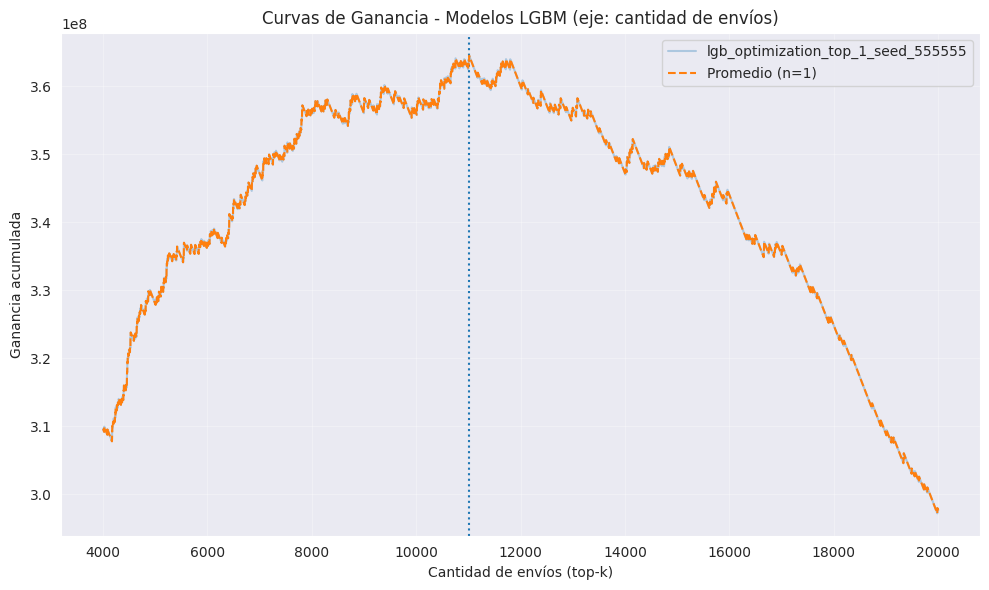

{'lgb_optimization_top_1_seed_555555': {'k': 11014, 'ganancia': 364500000.0, 'thr_opt': 0.023185348806239493}, 'PROMEDIO': {'k': 11014, 'ganancia': 364500000.0, 'thr_opt': 0.023185348806239493}}


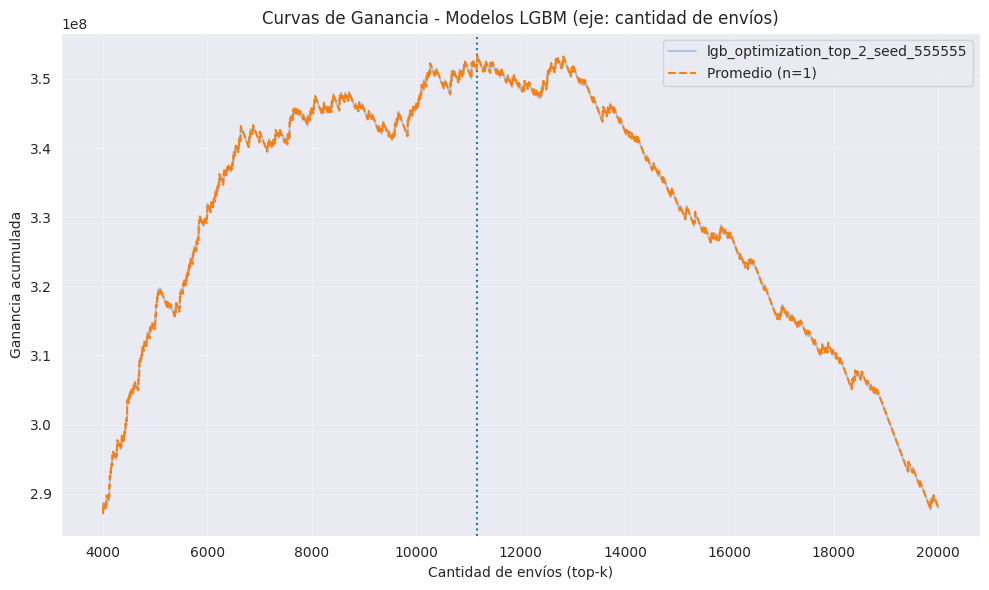

{'lgb_optimization_top_2_seed_555555': {'k': 11171, 'ganancia': 353360000.0, 'thr_opt': 0.014321992857579501}, 'PROMEDIO': {'k': 11171, 'ganancia': 353360000.0, 'thr_opt': 0.014321992857579501}}


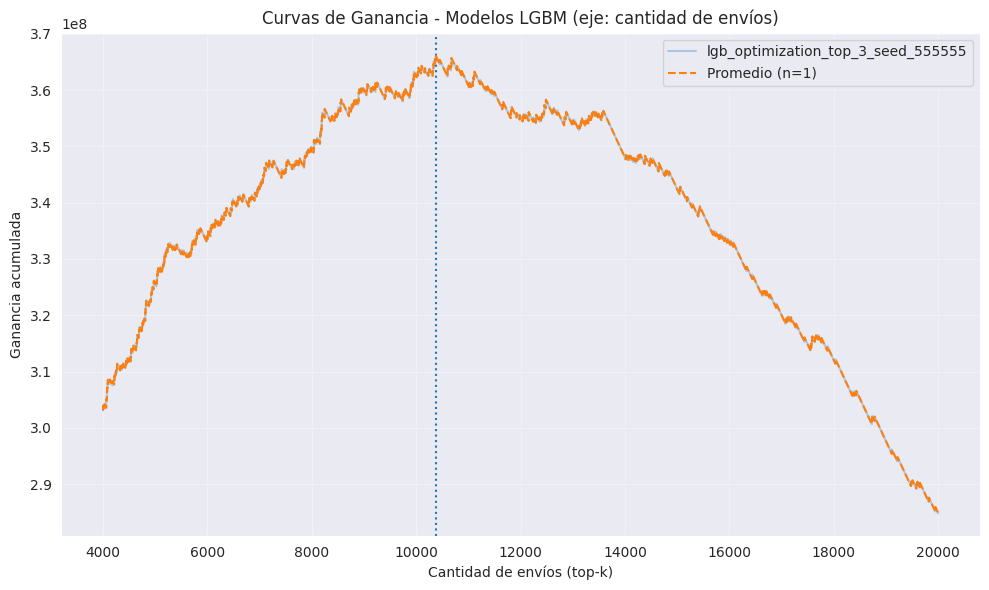

{'lgb_optimization_top_3_seed_555555': {'k': 10373, 'ganancia': 366120000.0, 'thr_opt': 0.03450861865720722}, 'PROMEDIO': {'k': 10373, 'ganancia': 366120000.0, 'thr_opt': 0.03450861865720722}}


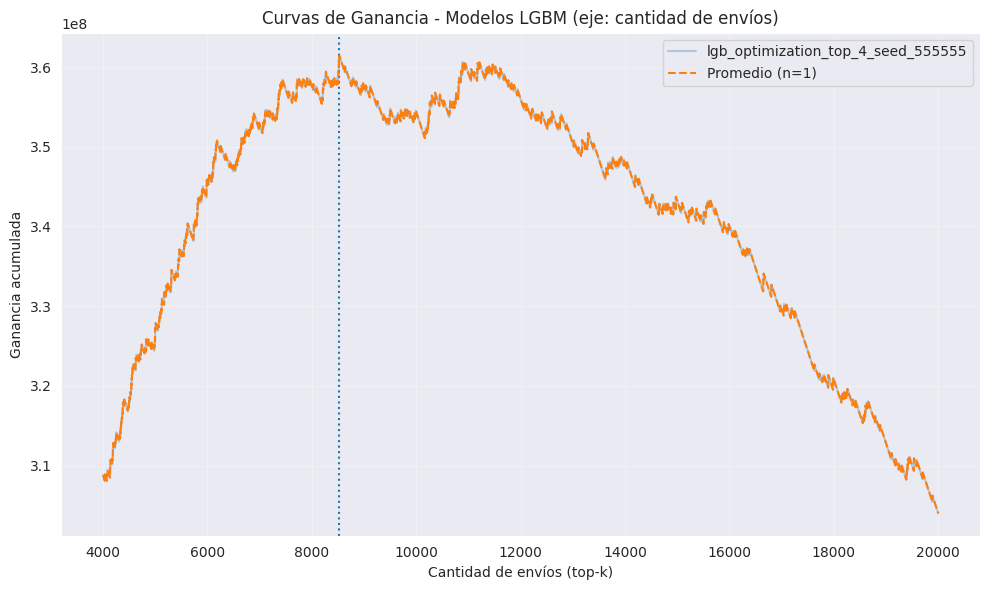

{'lgb_optimization_top_4_seed_555555': {'k': 8528, 'ganancia': 361420000.0, 'thr_opt': 0.04043242997859578}, 'PROMEDIO': {'k': 8528, 'ganancia': 361420000.0, 'thr_opt': 0.04043242997859578}}


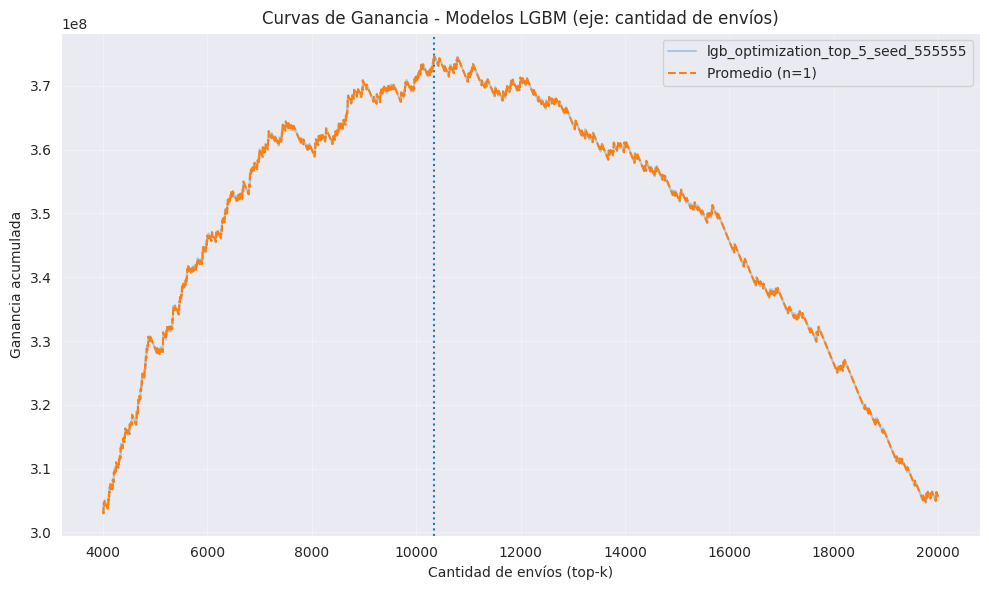

{'lgb_optimization_top_5_seed_555555': {'k': 10343, 'ganancia': 374720000.0, 'thr_opt': 0.036833204876039825}, 'PROMEDIO': {'k': 10343, 'ganancia': 374720000.0, 'thr_opt': 0.036833204876039825}}


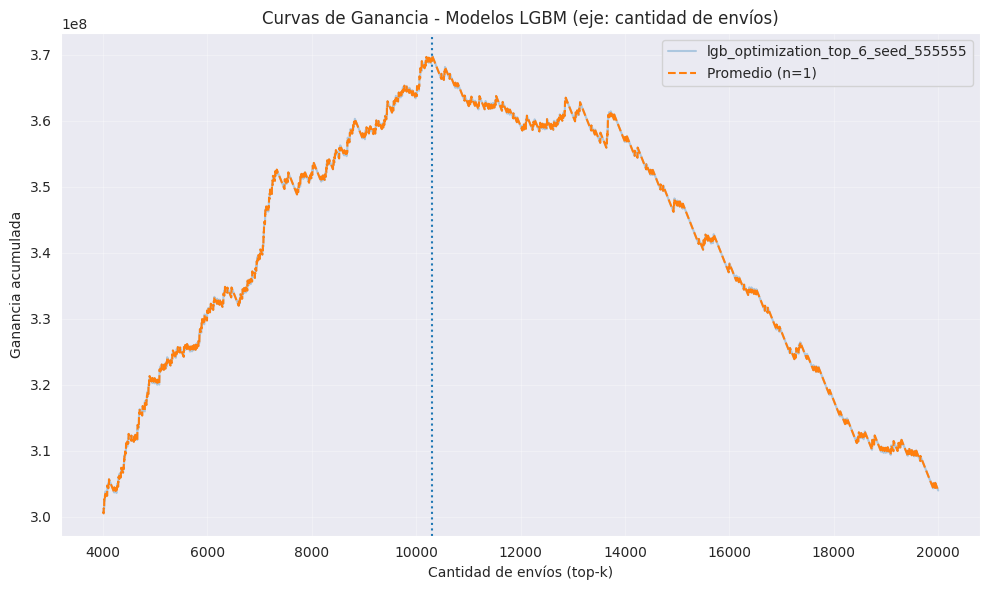

{'lgb_optimization_top_6_seed_555555': {'k': 10305, 'ganancia': 369880000.0, 'thr_opt': 0.033464780955571295}, 'PROMEDIO': {'k': 10305, 'ganancia': 369880000.0, 'thr_opt': 0.033464780955571295}}


In [74]:
import os
import re

txt_files = [f for f in os.listdir(dir_model_opt) if f.endswith('.txt')]

# Me quedo con los nombres de los modelos
titulos = [re.split(r'_seed', f)[0] for f in txt_files]
# tomar únicos para evitar repeticiones
modelos_unicos = sorted(set(titulos))

modelo_con_semillas = {}
for i in modelos_unicos:
    model_files = [model for model in txt_files if re.match(i, model)]
    modelo_con_semillas[i] = model_files

curvas = dict()
cortes = dict()
y_predicciones = dict()

for k in modelo_con_semillas:
    # print(dir_model_opt+k)
    y_predicciones[k], curvas[k], cortes[k] = calculo_curvas_ganancia(dir_model_opt,modelo_con_semillas[k])

###

In [99]:
rows = []
for modelo, seeds in cortes.items():
    for nombre_seed, valores in seeds.items():
        rows.append({
            'modelo': modelo,
            'semilla': nombre_seed,
            'k': valores['k'],
            'ganancia': valores['ganancia'],
            'thr_opt': valores['thr_opt']
        })

df= pd.DataFrame(rows)
df.to_csv(f'{dir_model_opt}modelos_puntos_de_corte.csv',index=False)

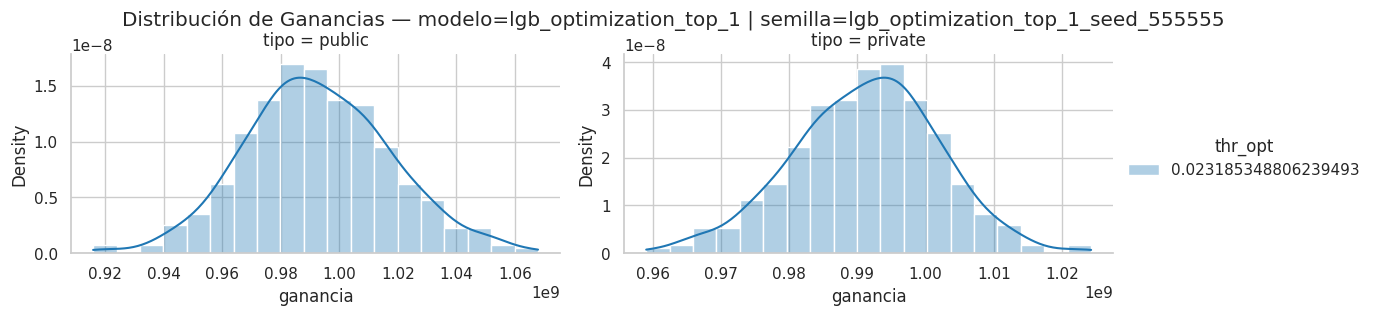

⏭️  Saltando modelo sin archivo: PROMEDIO


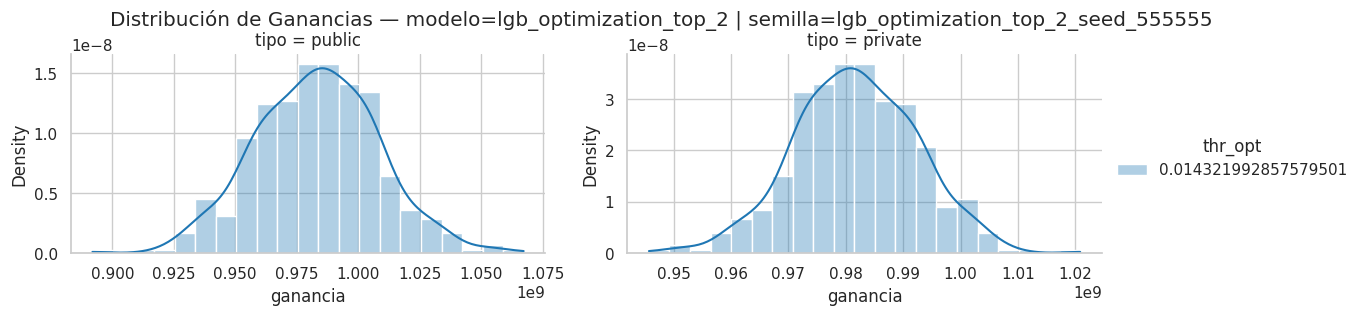

⏭️  Saltando modelo sin archivo: PROMEDIO


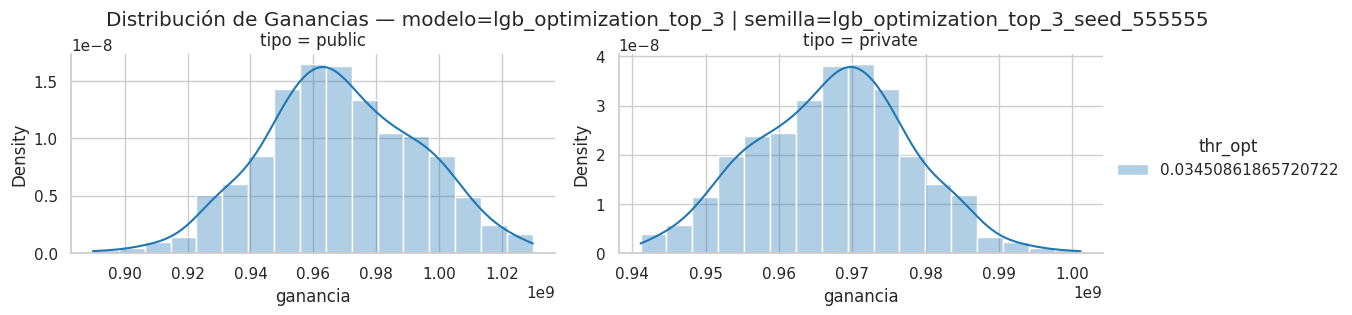

⏭️  Saltando modelo sin archivo: PROMEDIO


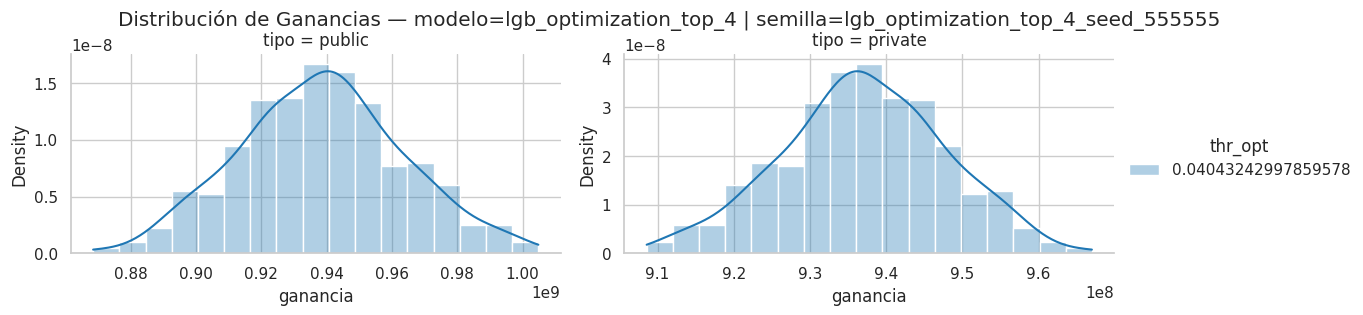

⏭️  Saltando modelo sin archivo: PROMEDIO


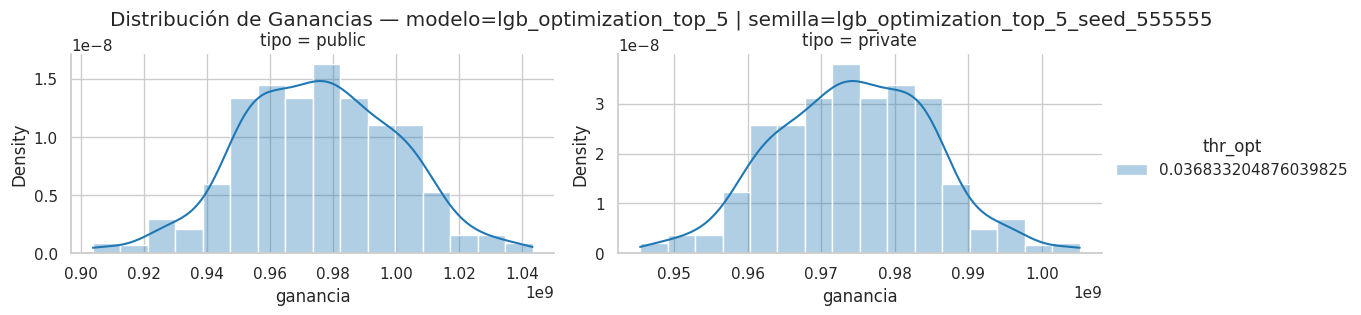

⏭️  Saltando modelo sin archivo: PROMEDIO
Gráficos generados:
 - /home/joacosk/Documents/maestria/Q2/proyecto/models/lgb_03/outputs_histos/lb_hist_lgb_optimization_top_1__lgb_optimization_top_1_seed_555555.png
 - /home/joacosk/Documents/maestria/Q2/proyecto/models/lgb_03/outputs_histos/lb_hist_lgb_optimization_top_2__lgb_optimization_top_2_seed_555555.png
 - /home/joacosk/Documents/maestria/Q2/proyecto/models/lgb_03/outputs_histos/lb_hist_lgb_optimization_top_3__lgb_optimization_top_3_seed_555555.png
 - /home/joacosk/Documents/maestria/Q2/proyecto/models/lgb_03/outputs_histos/lb_hist_lgb_optimization_top_4__lgb_optimization_top_4_seed_555555.png
 - /home/joacosk/Documents/maestria/Q2/proyecto/models/lgb_03/outputs_histos/lb_hist_lgb_optimization_top_5__lgb_optimization_top_5_seed_555555.png


In [58]:

# ===== Config =====
MODEL_PATH = dir_model_opt
OUT_DIR = f'{dir_model_opt}outputs_histos'
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# CSV -> df (si ya lo tenés en df, omití esta línea)
# df_cut = pd.read_csv('/ruta/a/modelos_puntos_de_corte.csv')
df_cut = df

assert {'modelo','semilla','thr_opt'}.issubset(df_cut.columns), \
    "El DataFrame debe tener columnas: modelo, semilla, thr_opt"

# 1) Mapear: por cada 'modelo' -> conjunto de thr_opt disponibles (únicos)
thr_opts_by_modelo = (
    df_cut[['modelo','thr_opt']]
    .drop_duplicates()
    .groupby('modelo')['thr_opt']
    .apply(list)
    .to_dict()
)

def ganancia_prob(y_pred, y_true, thr_opt, prop=1.0):
    ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
    return ganancia[y_pred >= thr_opt].sum() / prop

def file_with_txt(name: str) -> str:
    return name if name.endswith('.txt') else f"{name}.txt"

# >>> seeds: array/list con 5 seeds (ya lo tenés)
seeds = [151515, 155555, 515151, 551155, 555555]  # ejemplo

sns.set(style="whitegrid")

graficos_generados = []

for _, row in df_cut.iterrows():
    modelo = row['modelo']
    semilla_name = row['semilla']
    thr_opts = thr_opts_by_modelo.get(modelo, [])
    if not thr_opts:
        continue

    ### --- cambio --- ###
    model_path = os.path.join(MODEL_PATH, file_with_txt(semilla_name))
    try:
        # saltar PROMEDIO o cualquier modelo sin archivo
        if semilla_name == "PROMEDIO" or not os.path.exists(model_path):
            print(f"⏭️  Saltando modelo sin archivo: {semilla_name}")
            continue

        booster = lgb.Booster(model_file=model_path)
        y_pred_lgm = booster.predict(Xif)

    except Exception as e:
        print(f"⚠️  Error cargando modelo '{semilla_name}': {e}")
        continue
    ### --- fin cambio --- ###

    # 2.b) Correr SSS para TODAS las seeds y para CADA thr_opt
    rows_out = []
    for s in seeds:
        sss_futuro = StratifiedShuffleSplit(n_splits=100, test_size=0.3, random_state=s)
        for private_index, public_index in sss_futuro.split(Xif, y_test_binaria2):
            for thr in thr_opts:
                g_pub = ganancia_prob(y_pred_lgm[public_index],  y_test_binaria2[public_index],  thr, prop=0.3)
                g_pri = ganancia_prob(y_pred_lgm[private_index], y_test_binaria2[private_index], thr, prop=0.7)
                rows_out.append({
                    'modelo': modelo,
                    'semilla': semilla_name,
                    'thr_opt': float(thr),
                    'ganancia_public':  g_pub,
                    'ganancia_private': g_pri,
                    'seed': s
                })

    df_lb = pd.DataFrame(rows_out)

    df_long = df_lb.melt(
        id_vars=['modelo','semilla','thr_opt','seed'],
        value_vars=['ganancia_public','ganancia_private'],
        var_name='tipo',
        value_name='ganancia'
    )
    df_long['tipo'] = df_long['tipo'].str.replace('ganancia_', '', regex=False)

    g = sns.FacetGrid(
        df_long,
        col="tipo",
        sharex=False,
        sharey=False,
        hue="thr_opt",
        palette="tab10",
        height=3.2,
        aspect=1.8
    )
    g.map(sns.histplot, "ganancia", kde=True, stat="density", common_norm=False, alpha=0.35)
    g.add_legend(title="thr_opt")

    suptitle = f"Distribución de Ganancias — modelo={modelo} | semilla={semilla_name}"
    plt.subplots_adjust(top=0.84)
    g.fig.suptitle(suptitle)

    out_png = os.path.join(OUT_DIR, f"lb_hist_{modelo}__{semilla_name}.png")
    plt.savefig(out_png, dpi=150, bbox_inches='tight')
    plt.show()

    graficos_generados.append(out_png)

print("Gráficos generados:")
for p in graficos_generados:
    print(" -", p)


### Combino predicciones de los 5 modelos

In [ ]:
def ganancia_prob(y_pred, y_true, thr_opt, prop = 1):
  ganancia = np.where(y_true == 1, ganancia_acierto, 0) - np.where(y_true == 0, costo_estimulo, 0)
  return ganancia[y_pred >= thr_opt].sum() / prop

print("Ganancia LGBM:", ganancia_prob(y_pred_lgm, y_test_class,thr_opt))

In [127]:
topts = [0.023,0.014,0.035,0.04,0.037]

df_lgb_optimization_top_1 = y_predicciones['lgb_optimization_top_1'][0]
df_lgb_optimization_top_2 = y_predicciones['lgb_optimization_top_2'][0]
df_lgb_optimization_top_3 = y_predicciones['lgb_optimization_top_3'][0]
df_lgb_optimization_top_4 = y_predicciones['lgb_optimization_top_4'][0]
df_lgb_optimization_top_5 = y_predicciones['lgb_optimization_top_5'][0]


df_lgb_optimization_top_1['clase_ternaria_pred'] = df_lgb_optimization_top_1.y_pred >= 0.023
df_lgb_optimization_top_2['clase_ternaria_pred'] = df_lgb_optimization_top_2.y_pred >= 0.014
df_lgb_optimization_top_3['clase_ternaria_pred'] = df_lgb_optimization_top_3.y_pred >= 0.035
df_lgb_optimization_top_4['clase_ternaria_pred'] = df_lgb_optimization_top_4.y_pred >= 0.04
df_lgb_optimization_top_5['clase_ternaria_pred'] = df_lgb_optimization_top_5.y_pred >= 0.037


In [129]:
import pandas as pd

# Merge secuencial por las claves
df_final = (
    df_lgb_optimization_top_1[['numero_de_cliente', 'foto_mes', 'clase_ternaria_pred']]
    .merge(df_lgb_optimization_top_2[['numero_de_cliente', 'foto_mes', 'clase_ternaria_pred']],
           on=['numero_de_cliente', 'foto_mes'], suffixes=('_1', '_2'))
    .merge(df_lgb_optimization_top_3[['numero_de_cliente', 'foto_mes', 'clase_ternaria_pred']],
           on=['numero_de_cliente', 'foto_mes'])
    .merge(df_lgb_optimization_top_4[['numero_de_cliente', 'foto_mes', 'clase_ternaria_pred']],
           on=['numero_de_cliente', 'foto_mes'], suffixes=('_3', '_4'))
    .merge(df_lgb_optimization_top_5[['numero_de_cliente', 'foto_mes', 'clase_ternaria_pred']],
           on=['numero_de_cliente', 'foto_mes'])
)

# Renombrar columnas de predicciones
df_final.columns = [
    'numero_de_cliente', 'foto_mes',
    'clase_1', 'clase_2', 'clase_3', 'clase_4', 'clase_5'
]

# Convertir a int para poder sumar (True=1, False=0)
for col in ['clase_1', 'clase_2', 'clase_3', 'clase_4', 'clase_5']:
    df_final[col] = df_final[col].astype(int)

# Calcular cantidad de modelos que predijeron True
df_final['count_true'] = df_final[['clase_1', 'clase_2', 'clase_3', 'clase_4', 'clase_5']].sum(axis=1)

# Asignar 1 si hay 4 o más True
df_final['pred_ensemble'] = (df_final['count_true'] >= 4).astype(int)

df_final.head()

,numero_de_cliente,foto_mes,clase_1,clase_2,clase_3,clase_4,clase_5,count_true,pred_ensemble
0,1067311952,202104,0,0,0,0,0,0,0
1,1067564933,202104,0,0,0,0,0,0,0
2,1067640125,202104,0,0,0,0,0,0,0
3,1067699485,202104,0,0,0,0,0,0,0
4,1068037069,202104,0,0,0,0,0,0,0


#### Entreno con abril

In [14]:
Xi_all = pd.concat([Xi, Xif], axis=0, ignore_index=True)
y_all_binaria2 = np.concatenate([y_train_binaria2, y_test_binaria2]).ravel()
w_all          = np.concatenate([w_train, w_test]).ravel().astype(float)

Xi_all['internet_lag_2'] = Xi_all['internet_lag_2'].astype("category")

train_data_all = lgb.Dataset(Xi_all,
                          label=y_all_binaria2,
                          weight=w_all)


In [ ]:
MODEL_PATH = '/home/joacosk/Documents/maestria/Q2/proyecto/models/lgb_03/'
MODEL_FILE = 'lgb_optimization_top_1_seed_555555.txt'
model_path = os.path.join(MODEL_PATH, MODEL_FILE)

# 1) Cargar el booster original
booster = lgb.Booster(model_file=model_path)

# 2) Extraer parámetros originales de forma segura
#    - booster.params: suele traerlos, pero a veces es parcial
#    - dump_model(): trae todo; buscamos ahí si falta algo
orig_params = dict(booster.params) if getattr(booster, "params", None) else {}
dump = booster.dump_model()
# LightGBM cambia ligeramente la estructura según versión; chequeamos varias rutas
dump_params = {}
if isinstance(dump, dict):
    # intentos comunes
    dump_params = dump.get('learner', {}).get('params', {}) or dump.get('params', {}) or {}

# merge: dump_params > orig_params
for k, v in dump_params.items():
    orig_params.setdefault(k, v)

# 3) Construir dict 'top4' con hiperparámetros que querés recuperar del modelo
def _get(name, default=None, cast=None):
    val = orig_params.get(name, default)
    if cast and val is not None:
        try:
            val = cast(val)
        except Exception:
            pass
    return val

top4 = {
    'num_leaves':        _get('num_leaves',        31,   int),
    'min_data_in_leaf':  _get('min_data_in_leaf',  20,   int),
    'learning_rate':     _get('learning_rate',     0.05, float),
    'feature_fraction':  _get('feature_fraction',  1.0,  float),
    'bagging_fraction':  _get('bagging_fraction',  1.0,  float),
}

for seed in [151515, 155555, 515151, 551155] :
    # 4) Armar los nuevos params (cambiar a Binaria2)
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,

        # Árbol
        'num_leaves': top4['num_leaves'],
        'min_data_in_leaf': top4['min_data_in_leaf'],
        'learning_rate': top4['learning_rate'],

        # Column sampling
        'feature_fraction': top4['feature_fraction'],
        # 'feature_fraction_bynode': <si lo usabas, podés traerlo de orig_params>,

        # Bagging
        'bagging_fraction': top4['bagging_fraction'],
        # 'bagging_freq': top4['bagging_freq'] if top4['bagging_freq'] is not None else 0,

        # Semilla (usa la que quieras de tu array 'seeds')
        'seed': seeds[1],
        'bagging_freq': 1,
        'extra_trees': True,
        'verbose': -1
    }

    # 5) Tomar cantidad de iteraciones del modelo original para reutilizar como num_boost_round
    #    Preferimos .best_iteration si existe (p.ej. si hubo early stopping); si no, usamos current_iteration()
    best_iter = getattr(booster, "best_iteration", None)
    if not best_iter or best_iter <= 0:
        best_iter = booster.current_iteration()

    print(f"[INFO] best_iter = {best_iter}")
    print(f"[INFO] top4: {top4}")

    # 6) Asegurar que 'Xi' tenga exactamente el mismo orden de columnas que el modelo esperaba (opcional pero sano)
    #    Si tenés el listado original:
    model_features = booster.feature_name()
    # Xi = Xi[model_features]   # descomentar si necesitás forzar el orden

    # 7) Dataset y entrenamiento (CAMBIAR A BINARIA 2)
    # train_data = lgb.Dataset(
    #     Xi,
    #     label=y_train_binaria2,
    #     weight=w_train,
    #     feature_name=model_features  # opcional: ayuda a mantener trazabilidad
    # )

    model = lgb.train(
        params=params,
        train_set=train_data_all,
        num_boost_round=best_iter
    )

    # (Opcional) guardar el nuevo modelo
    model.save_model(f'/home/joacosk/Documents/maestria/Q2/proyecto/models/lgb_03/train_abril/{MODEL_FILE}_retrained_seed_{seed}.txt')


[INFO] best_iter = 345
[INFO] top4: {'num_leaves': 140, 'min_data_in_leaf': 203, 'learning_rate': 0.0412217, 'feature_fraction': 0.795234, 'bagging_fraction': 0.552853}


### Predicción

In [10]:
import lightgbm as lgbm
import os

In [11]:
MODEL_PATH = '/home/joacosk/Documents/maestria/Q2/proyecto/models/lgb_03/train_abril/'
MODEL_FILE = 'lgb_optimization_top_1_seed_555555_retrained.txt'
model_path = os.path.join(MODEL_PATH, MODEL_FILE)
model = lgbm.Booster(model_file=f'{MODEL_PATH}{MODEL_FILE}')

modelo = 1
thr_opt = 0.0231
thr_opts = [0.0231, 0.03, 0.04, 0.045 , 0.05]

In [12]:
# Debido a una discrepancia en feature enginering debo hacer esto acá
Xipred['internet_lag_2'] = Xipred['internet_lag_2'].astype("category")


In [13]:

## Linea de corte establecida con treshold
from datetime import datetime
import subprocess

# data_pred.columns[data_pred.columns.str.contains('clase')]
# data_pred.shape
# #pred_data = data.filter(pl.col("foto_mes") == 202106)
# X_pred = data_pred.drop(["clase_ternaria"], axis=1)
#
# X_pred[matching_categorical_features] = X_pred[matching_categorical_features].astype("category")

y_pred_202106_lgm = model.predict(Xipred)

tiempo = datetime.now().strftime('%Y%m%d_%H_%M_%Ss')

num_clientes = Xipred['numero_de_cliente']
### thr_opt lo calculé luego de armar la curva de  ganancia.
# Lo seteo un par de celdas más arriba

for thr_opt in thr_opts:
    #thr_opt = thr_opt
    y_churn = np.where(y_pred_202106_lgm >= thr_opt, 1, 0)

    df_churn = pd.DataFrame({
        "numero_de_cliente": num_clientes,
        "Predicted": y_churn
    })

    filename = f'/home/joacosk/Documents/maestria/Q2/proyecto/submissions/second_lgbm_optimization_{tiempo}_thr_{thr_opt}_TOP{modelo}_{seed}.csv'
    df_churn.to_csv(f'{filename}', index=False)

    print(f"✅ Archivo guardado: {filename}")

    # ID de la competencia (por ejemplo, 'dm-ey-f-2025-primera')
    competition = "dm-ey-f-2025-primera"

    # Mensaje de submit
    message = f"Auto submit generado el {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

    # Enviar el archivo a Kaggle
    try:
        result = subprocess.run(
            ["kaggle", "competitions", "submit", "-c", competition, "-f", filename, "-m", message],
            check=True,
            capture_output=True,
            text=True
        )
        print("🚀 Envío realizado correctamente:")
        print(result.stdout)
    except subprocess.CalledProcessError as e:
        print("❌ Error al hacer el submit:")
        print(e.stderr)


✅ Archivo guardado: /home/joacosk/Documents/maestria/Q2/proyecto/submissions/second_lgbm_optimization_20251012_20_48_57s_thr_0.0231_TOP1_155555.csv
🚀 Envío realizado correctamente:
Successfully submitted to DMEyF 2025 Primera
✅ Archivo guardado: /home/joacosk/Documents/maestria/Q2/proyecto/submissions/second_lgbm_optimization_20251012_20_48_57s_thr_0.03_TOP1_155555.csv
🚀 Envío realizado correctamente:
Successfully submitted to DMEyF 2025 Primera
✅ Archivo guardado: /home/joacosk/Documents/maestria/Q2/proyecto/submissions/second_lgbm_optimization_20251012_20_48_57s_thr_0.04_TOP1_155555.csv
🚀 Envío realizado correctamente:
Successfully submitted to DMEyF 2025 Primera
✅ Archivo guardado: /home/joacosk/Documents/maestria/Q2/proyecto/submissions/second_lgbm_optimization_20251012_20_48_57s_thr_0.045_TOP1_155555.csv
🚀 Envío realizado correctamente:
Successfully submitted to DMEyF 2025 Primera
✅ Archivo guardado: /home/joacosk/Documents/maestria/Q2/proyecto/submissions/second_lgbm_optimization